# Analysis on 2D Heisenberg model

In [1]:
import multiprocessing
import sys
import os
from pathlib import Path
from time import time
from typing import Tuple
from socket import gethostname

import pandas as pd
import numpy as np
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
from cycler import cycler
from tqdm.notebook import tqdm

# set plot customisation
plt.rc('font',**{'family':'serif',
             'serif': 'cmr10',
             'size': 12})
plt.rc('mathtext',**{'fontset':'cm'})
plt.rc('axes', unicode_minus=False, linewidth=1.2, xmargin=0)
plt.rc('legend', loc='best', frameon=False)

from heisenberg_2d import initialize, metropolis, energy, magnetization, run_simulation

## Run the routine

In [2]:
# Settings

n_temp = 50
data_path = './results'
snaps = []

N = 8
H = np.array([1., 0., 0.])
steps = 4000
temp = np.linspace(0.3, 10.5, n_temp)

In [3]:
*results, wall_time = run_simulation(N, H, steps, temp)
results = np.array(results).T

Using 80 threads on brute



Took 29.263503789901733 s


### Save results

In [4]:
# mkdir in case
if not os.path.exists(data_path):
    os.makedirs(data_path)

# gather results in a table just in case
df = pd.DataFrame(results, columns=['E', 'M', 'C', 'X'])
df['temp'] = temp
for name, var in zip(['n_temp', 'N', 'steps', 'H', 'wall_time'], [n_temp, N, steps, [H] * n_temp, wall_time]):
    df[name] = var
    
# save the table
df.to_csv(f'{data_path}/data_{n_temp}_{N}_{steps}_{H}.csv', sep=',', header=True, index=False)
display(df)

,E,M,C,X,temp,n_temp,N,steps,H,wall_time
0,-0.443371,-0.324433,0.002532,0.035052,0.300000,50,8,4000,"[1.0, 0.0, 0.0]",29.263504
1,-0.560676,0.223794,0.008563,0.010075,0.508163,50,8,4000,"[1.0, 0.0, 0.0]",29.263504
2,-0.659157,0.686418,0.011341,0.118476,0.716327,50,8,4000,"[1.0, 0.0, 0.0]",29.263504
3,-0.684673,0.695596,0.016856,0.068166,0.924490,50,8,4000,"[1.0, 0.0, 0.0]",29.263504
4,-0.667149,0.874787,0.028299,0.224131,1.132653,50,8,4000,"[1.0, 0.0, 0.0]",29.263504
5,-0.615006,0.779082,0.050747,0.613562,1.340816,50,8,4000,"[1.0, 0.0, 0.0]",29.263504
6,-0.548915,0.740473,0.077945,1.038498,1.548980,50,8,4000,"[1.0, 0.0, 0.0]",29.263504
7,-0.469830,0.648139,0.074368,0.660310,1.757143,50,8,4000,"[1.0, 0.0, 0.0]",29.263504
8,-0.397009,0.578444,0.077676,0.696118,1.965306,50,8,4000,"[1.0, 0.0, 0.0]",29.263504
9,-0.316434,0.475733,0.060115,0.793594,2.173469,50,8,4000,"[1.0, 0.0, 0.0]",29.263504


# Show all results

In [2]:
data_path = './results'

dfs = [pd.read_csv(f) for f in Path.cwd().rglob(f'{data_path}/*.csv')]
df = pd.concat(dfs, axis=0, join='inner').sort_index()

In [3]:
# Limit sizes
df = df[df['N'] <= 200]
df

,E,M,C,X,temp,n_temp,N,steps,H,wall_time
0,-0.378843,0.598633,1.892052,1.128047,0.2,400,112,4000,[0. 0.5 0.86],2316.861832
0,-0.338853,-0.009411,0.077152,0.018227,0.2,400,32,4000,[0. 0. 0.],168.243150
0,-0.382756,0.363900,0.194924,0.136674,0.2,400,32,4000,[1. 0. 0.],157.709718
0,-0.422916,0.833259,0.228027,0.135707,0.2,400,32,4000,[1. 1. 1.],149.793159
0,-0.384748,0.605823,0.417926,0.263677,0.2,400,48,4000,[0. 0.5 0.86],325.607392
...,...,...,...,...,...,...,...,...,...,...
399,-0.031090,0.040939,0.000984,0.107211,10.0,400,160,4000,[1. 0. 0.],4502.634192
399,-0.031143,0.041522,0.000981,0.120111,10.0,400,48,4000,[1. 0. 0.],327.983945
399,-0.022922,-0.000188,0.000762,0.111231,10.0,400,64,4000,[0. 0. 0.],642.462919
399,-0.031068,0.041313,0.000970,0.117823,10.0,400,80,4000,[1. 0. 0.],1142.393397


## Plotting

Example of plotting all simulation data with a specific size $N$

In [13]:
# Uppermost for-loop is different external fields H
Hs = df['H'].unique()
figure_size = (4, 3)
marker_size = .6
figure_dir = './figures'

# mkdir in case
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
    
# set colors
colors = sns.color_palette('husl', n_colors=len(df['N'].unique()))
plt.rc('axes', prop_cycle=cycler('color', colors))

### Energy

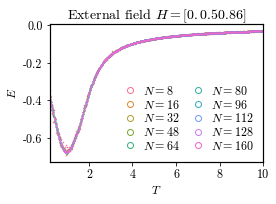

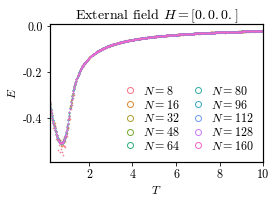

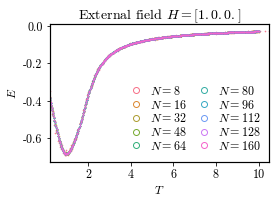

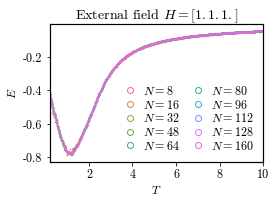

In [14]:
for H in Hs:
    
    # Select correct data
    dfh = df[(df['H'] == H)]
    
    plt.figure(figsize=figure_size)
    for N in sorted(dfh['N'].unique()):
        dfhn = dfh[dfh['N'] == N]
        E, M, C, X, temp, *_ = dfhn.values.T
        
        plt.title('External field $H={}$'.format(H))
        lines = plt.plot(temp, E, 'o' , markersize=marker_size, markerfacecolor="None", label=f'$N={N}$')
        plt.xlabel('$T$'); plt.ylabel('$E$');
    plt.legend(loc="lower right", markerscale=10, ncol=2, labelspacing=0.07, columnspacing=0.5, handletextpad=0.1)
    plt.tight_layout()
    plt.savefig(f'{figure_dir}/energy_{" ".join(str(H).split())}.pdf')
    plt.show()
    

###  Magnetisation

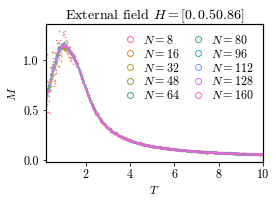

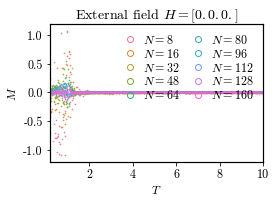

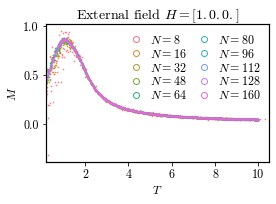

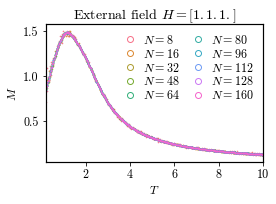

In [15]:
for H in Hs:
    
    # Select correct data
    dfh = df[(df['H'] == H)]
    
    plt.figure(figsize=figure_size)
    for N in sorted(dfh['N'].unique()):
        dfhn = dfh[dfh['N'] == N]
        E, M, C, X, temp, *_ = dfhn.values.T
        
        plt.title('External field $H={}$'.format(H))
        plt.plot(temp, M, 'o' , markersize=marker_size, markerfacecolor="None", label=f'$N={N}$')
        plt.xlabel('$T$'); plt.ylabel('$M$');
    plt.legend(loc="upper right", markerscale=10, ncol=2, labelspacing=0.07, columnspacing=0.5, handletextpad=0.1)
    plt.tight_layout()
    plt.savefig(f'{figure_dir}/magnetisation_{" ".join(str(H).split())}.pdf')
    plt.show()
    

###  Specific Heat

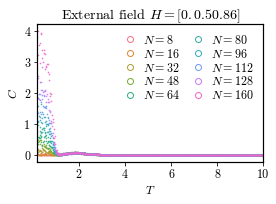

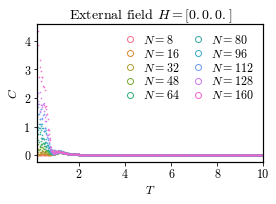

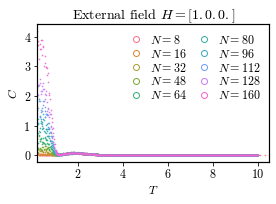

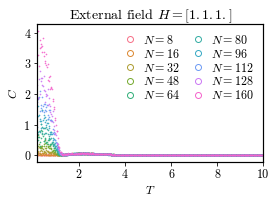

In [16]:
for H in Hs:
    
    # Select correct data
    dfh = df[(df['H'] == H)]
    
    plt.figure(figsize=figure_size)
    for N in sorted(dfh['N'].unique()):
        dfhn = dfh[dfh['N'] == N]
        E, M, C, X, temp, *_ = dfhn.values.T
        
        plt.title('External field $H={}$'.format(H))
        plt.plot(temp, C, 'o' , markersize=marker_size, markerfacecolor="None", label=f'$N={N}$')
        plt.xlabel('$T$'); plt.ylabel('$C$');
    plt.legend(loc="upper right", markerscale=10, ncol=2, labelspacing=0.07, columnspacing=0.5, handletextpad=0.1)
    plt.tight_layout()
    plt.savefig(f'{figure_dir}/cv_{" ".join(str(H).split())}.pdf')
    plt.show()
    

###  Susceptibility

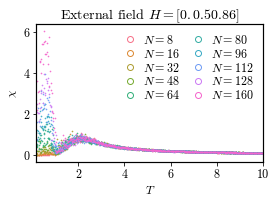

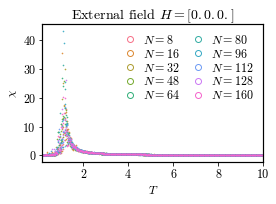

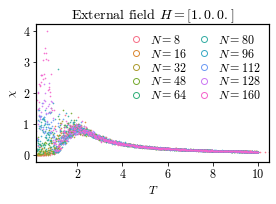

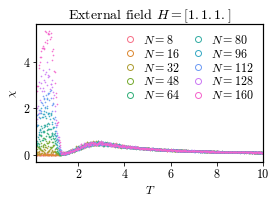

In [17]:
def power_law(T, a, b):
    return a * np.exp( b / T) / T  #np.power(x, 3./2.)  # TODO what?

for H in Hs:
    
    # Select correct data
    dfh = df[(df['H'] == H)]
    
    plt.figure(figsize=(figure_size[0] * 1, figure_size[1] * 1.0))
    for N in sorted(dfh['N'].unique()):
        dfhn = dfh[dfh['N'] == N]
        E, M, C, X, temp, *_ = dfhn.values.T
        
        plt.title('External field $H={}$'.format(H))
        plt.plot(temp, X, 'o' , markersize=marker_size, markerfacecolor="None", label=f'$N={N}$')
        plt.xlabel('$T$'); plt.ylabel('$\chi$');
    
    # fit power law with all data
    temp = dfh['temp'].sort_values()
    error = dfh.pivot_table(values=['X'], index='temp', aggfunc=np.std).values[:,-1] ** (0.70)
    error = np.repeat(error, len(dfh['N'].unique()))
#     temp = error.index.values
#     error = error.values[:,-1]
#     x = dfh.pivot_table(values=['X'], index='temp', aggfunc=np.mean).values[:,-1]
#     print(temp.shape, x.shape, error.shape)
    
#     try:
#         popt, pcov = scipy.optimize.curve_fit(power_law, dfh['temp'], dfh['X'], sigma=error, absolute_sigma=True)
#     except ValueError as e:
#         popt, pcov = scipy.optimize.curve_fit(power_law, dfh['temp'], dfh['X'])
#     plt.plot(temp, power_law(temp, *popt), '--', label=f'fit: ${popt[0]:.3f}\\cdot\\exp({popt[1]:.3f}/T)/T$')
    
    plt.legend(loc="upper right", markerscale=10, ncol=2, labelspacing=0.07, columnspacing=0.5, handletextpad=0.1)
    plt.tight_layout()
    plt.savefig(f'{figure_dir}/susceptibility_{" ".join(str(H).split())}.pdf')
    plt.show()
    

### N vs. time figure
Gather all data and compare with $N$

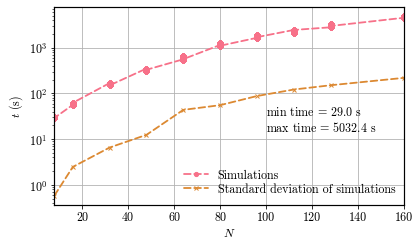

In [18]:
dfs = df.sort_values(by=['N'])
dfs['wall_time']

plt.figure(figsize=(figure_size[0] * 1.5, figure_size[1] * 1.2))
plt.semilogy(dfs['N'], dfs['wall_time'], 'o--', label="Simulations")
plt.xlabel('$N$'); plt.ylabel('$t$ (s)')
plt.text(100, 15, f"$\min$ time = {dfs['wall_time'].min():.1f} s\n$\max$ time = {dfs['wall_time'].max():.1f} s")

std = dfs.groupby("N").std()["wall_time"]
plt.semilogy(std.index, std, 'x--', label="Standard deviation of simulations")

plt.legend(loc="lower right", markerscale=1, ncol=1, labelspacing=0.15)
plt.grid()
plt.tight_layout()

plt.savefig(f'{figure_dir}/NvsTime.pdf')
plt.show()

### Get random table
To show in the report the format of data tables

In [15]:
# Get random table
dfffff = df.sample(5).sort_values(by=['N'])
dfffff

,E,M,C,X,temp,n_temp,N,steps,H,wall_time
368,-0.034269,0.049047,0.001088,0.128402,9.238596,400,16,4000,[1. 0. 0.],62.124650
156,-0.097163,0.139819,0.009058,0.375774,4.031579,400,48,4000,[1. 0. 0.],327.983945
251,-0.037099,-0.001837,0.002069,0.196200,6.364912,400,64,4000,[0. 0. 0.],642.462919
369,-0.052078,0.135020,0.001695,0.139142,9.263158,400,64,4000,[1. 1. 1.],524.563709
303,-0.042260,0.056733,0.001675,0.160289,7.642105,400,160,4000,[1. 0. 0.],4502.634192


In [37]:
# Export to latex
print(dfffff.to_latex(escape=False, bold_rows=True, column_format='c', index=False, float_format=lambda s: f'{s:.4f}'))

\begin{tabular}{c}
\toprule
      E &       M &      C &      X &   temp &  n_temp &    N &  steps &           H &  wall_time \\
\midrule
-0.0343 &  0.0490 & 0.0011 & 0.1284 & 9.2386 &     400 &   16 &   4000 &  [1. 0. 0.] &    62.1247 \\
-0.0972 &  0.1398 & 0.0091 & 0.3758 & 4.0316 &     400 &   48 &   4000 &  [1. 0. 0.] &   327.9839 \\
-0.0371 & -0.0018 & 0.0021 & 0.1962 & 6.3649 &     400 &   64 &   4000 &  [0. 0. 0.] &   642.4629 \\
-0.0521 &  0.1350 & 0.0017 & 0.1391 & 9.2632 &     400 &   64 &   4000 &  [1. 1. 1.] &   524.5637 \\
-0.0423 &  0.0567 & 0.0017 & 0.1603 & 7.6421 &     400 &  160 &   4000 &  [1. 0. 0.] &  4502.6342 \\
\bottomrule
\end{tabular}

